In [139]:
import pandas as pd
import numpy  as np

import data file

In [140]:
df = pd.read_csv('data_new.csv')
df.describe()

,Label
count,329.000000
mean,0.589666
std,0.492644
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


split data

In [141]:
print("Non-cheat: ", len(df[df['Label']==0]))
print("Cheat: ", len(df[df['Label']==1]))

# diff = abs(len(df[df['Label']==0]) - len(df[df['Label']==1]))

grouped = df.groupby(df.Label)
df1 = grouped.get_group(1)
df2 = grouped.get_group(0)

df2_1 = df.iloc[:135,:]
df2_2 = df.iloc[135:194,:]

df1_train = df1.iloc[:111,:]
df2_train = df2_1.iloc[:111,:]

df1_test = df1.iloc[111:135,:]
df2_test = df2_1.iloc[111:135,:]

train = pd.concat([df1_train, df2_train])
test  = pd.concat([df1_test, df2_test, df2_2])

print((len(train), len(test)))

Non-cheat:  135
Cheat:  194
(222, 107)


parse data from string to numpy array

In [142]:
def parseData(series):
    final_series = []
    for ser in series:
        temp = []
        for x in "[],":
            ser = ser.replace(x, "")
        new_ser  = np.fromstring(ser, dtype=float, sep=" ")
        for i in range(0, len(new_ser), 3):
            chunk = [new_ser[i], new_ser[i + 1], new_ser[i + 2]]
            temp.append(chunk)
        final_series.append(temp)
    return np.array(final_series, dtype=object)

get the longest sequence of vector in dataset

In [143]:
max_length = 0
for lgaze in parseData(df['Left Gaze']):
    if len(lgaze) > max_length:
        max_length = len(lgaze)
        
max_length

1294

pad the dataset to the longest sequence size

In [144]:
import math

def padData(series, length):
    for idx, ser in enumerate(series):
        times = math.floor(length / len(ser))
        add = length % len(ser)
        
        temp = ser[::-1]
        for _ in range(1, times):
            series[idx] = np.append(series[idx], temp, axis=0)
            temp = temp[::-1]
        if add != 0:
            series[idx] = np.append(series[idx], temp[0:add], axis=0)
    return series

Conv1D -> AveragePooling1D -> Conv1D -> AveragePooling1D -> LSTM -> Dense

In [145]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, AveragePooling1D, LSTM
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, History

import tensorflow as tf

def init_model():
    model = Sequential()
    model.add(Conv1D(filters=12, kernel_size=3, padding="same", activation='relu', input_shape=(max_length, 12)))
    model.add(AveragePooling1D(pool_size=2))
    model.add(Conv1D(filters=12, kernel_size=3, padding="same", activation='relu', input_shape=(max_length, 12)))
    model.add(AveragePooling1D(pool_size=2))
    
    model.add(LSTM(12))
    
    adam = optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    
    model.add(Flatten())
    model.add(Dense(2, activation = 'softmax')) # We have only 2 classes: Non-cheat & Cheat
    
    model.compile(optimizer=adam,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


normalize the data

In [146]:
def normalize(data, a, b):
    # Reshape the data to work on each feature separately
    reshaped_data = tf.reshape(data, (-1, data.shape[-1]))

    # Calculate min and max values for each feature
    min_vals = tf.reduce_min(reshaped_data, axis=0)
    max_vals = tf.reduce_max(reshaped_data, axis=0)

    # Normalize to range [a, b]
    normalized_data = (b - a) * (reshaped_data - min_vals) / (max_vals - min_vals + 1e-8) + a
    
    # Reshape back to the original shape
    normalized_data = tf.reshape(normalized_data, data.shape)

    return normalized_data

In [147]:
right_gaze_train = train["Right Gaze"]
left_gaze_train  = train["Left Gaze"]
right_head_train = train["Right HeadPose"]
left_head_train  = train["Left HeadPose"]

label_train = train['Label']

right_gaze_train, left_gaze_train, right_head_train, left_head_train = parseData(right_gaze_train), parseData(left_gaze_train), parseData(right_head_train), parseData(left_head_train)

initialize new data frame

In [148]:
left_head_train  = padData(left_head_train,  max_length)
right_head_train = padData(right_head_train, max_length)
left_gaze_train  = padData(left_gaze_train,  max_length)
right_gaze_train = padData(right_gaze_train, max_length)

In [149]:
label_train = np.array(label_train)

In [150]:
y_train = []
for i in range(len(label_train)):
    y_train.append(
        tf.convert_to_tensor(
            np.reshape(tf.keras.utils.to_categorical(label_train[i], num_classes=2), (1, 2))                 
                            )
             )
    
y_train = tf.convert_to_tensor(np.vstack(y_train), dtype=tf.float32)

In [151]:
x_train = []

for i in range(len(left_gaze_train)):
    x_train.append(tf.convert_to_tensor([
                                            np.hstack(
                                                        (left_gaze_train[i], right_gaze_train[i], left_head_train[i], right_head_train[i])
                                                     )
                                            ], dtype=tf.float32))



x_train = tf.convert_to_tensor(np.vstack(x_train), dtype=tf.float32)

x_train = normalize(x_train, -1, 1)

print(x_train)

print(y_train)

tf.Tensor(
[[[ 0.4546013   0.38279557  0.00875044 ... -0.07185304 -0.37140948
   -0.01837873]
  [ 0.4540676   0.38292718  0.00642347 ... -0.11790377 -0.3532024
   -0.07186544]
  [ 0.45393515  0.38318026  0.00624824 ... -0.11903268 -0.34125173
   -0.07702148]
  ...
  [ 0.4536072   0.38357365  0.00595248 ... -0.13198423 -0.30927277
   -0.09944957]
  [ 0.45319796  0.38280034  0.00633931 ... -0.1292842  -0.33742374
   -0.08601141]
  [ 0.45304024  0.38288152  0.00623596 ... -0.13575798 -0.33454007
   -0.09195441]]

 [[ 0.4553994   0.38179076  0.00858831 ...  0.04183686 -0.40991467
    0.08040249]
  [ 0.45443153  0.38204563  0.00823593 ... -0.00341254 -0.395041
    0.03842092]
  [ 0.4543016   0.38176835  0.00803065 ... -0.08474928 -0.35570383
   -0.05046135]
  ...
  [ 0.45404398  0.38191128  0.00710332 ... -0.0509119  -0.3825788
   -0.00487578]
  [ 0.45394516  0.38198256  0.00704563 ... -0.04154074 -0.37534434
    0.00430453]
  [ 0.45453238  0.38149536  0.00796998 ... -0.06808329 -0.3447706


Train the model

In [152]:
model = init_model()
callbacks = [EarlyStopping(monitor='loss', patience=3), History()]
history = model.fit(x_train, y_train, epochs=100, batch_size=128, callbacks=callbacks)

Epoch 1/100
2/2 [==============================] - 3s 134ms/step - loss: 0.6614 - accuracy: 0.8018
Epoch 2/100
2/2 [==============================] - 0s 127ms/step - loss: 0.6466 - accuracy: 0.8018
Epoch 3/100
2/2 [==============================] - 0s 134ms/step - loss: 0.6311 - accuracy: 0.8018
Epoch 4/100
2/2 [==============================] - 0s 131ms/step - loss: 0.6173 - accuracy: 0.8018
Epoch 5/100
2/2 [==============================] - 0s 131ms/step - loss: 0.6043 - accuracy: 0.8018
Epoch 6/100
2/2 [==============================] - 0s 131ms/step - loss: 0.5916 - accuracy: 0.8018
Epoch 7/100
2/2 [==============================] - 0s 130ms/step - loss: 0.5801 - accuracy: 0.8018
Epoch 8/100
2/2 [==============================] - 0s 131ms/step - loss: 0.5693 - accuracy: 0.8018
Epoch 9/100
2/2 [==============================] - 0s 131ms/step - loss: 0.5581 - accuracy: 0.8018
Epoch 10/100
2/2 [==============================] - 0s 132ms/step - loss: 0.5496 - accuracy: 0.8018
Epoch 11/

In [153]:
for layer in model.layers:
    print(layer.output_shape)

(None, 1294, 12)
(None, 647, 12)
(None, 647, 12)
(None, 323, 12)
(None, 12)
(None, 12)
(None, 2)


Predict test set

In [154]:
right_gaze_test = test["Right Gaze"]
left_gaze_test  = test["Left Gaze"]
right_head_test = test["Right HeadPose"]
left_head_test  = test["Left HeadPose"]

label_test = test['Label']

right_gaze_test, left_gaze_test, right_head_test, left_head_test = parseData(right_gaze_test), parseData(left_gaze_test), parseData(right_head_test), parseData(left_head_test)

In [155]:
left_head_test  = padData(left_head_test,  max_length)
right_head_test = padData(right_head_test, max_length)
left_gaze_test  = padData(left_gaze_test,  max_length)
right_gaze_test = padData(right_gaze_test, max_length)

In [156]:
x_test = []

for i in range(len(left_gaze_test)):
    x_test.append(tf.convert_to_tensor([
                                            np.hstack(
                                                        (left_gaze_test[i], right_gaze_test[i], left_head_test[i], right_head_test[i])
                                                     )
                                            ], dtype=tf.float32))



x_test = tf.convert_to_tensor(np.vstack(x_test), dtype=tf.float32)

print(x_test)

tf.Tensor(
[[[ 51.537  30.285  59.777 ...  53.407   8.105  54.019]
  [ 40.51   37.984  55.533 ...  48.782   6.237  49.179]
  [ 26.477  32.743  42.108 ...  41.713  14.326  44.104]
  ...
  [  9.333  36.422  37.598 ...  32.341  15.118  35.7  ]
  [ 32.112  34.174  46.894 ...  47.997  12.341  49.559]
  [ 25.442  29.643  39.064 ...  41.91    9.913  43.066]]

 [[ 29.547  18.415  34.815 ...  44.61    5.529  44.951]
  [ 28.973  18.207  34.219 ...  43.922   4.782  44.182]
  [ 43.92   15.941  46.724 ...  48.461   1.124  48.474]
  ...
  [ 39.393   9.628  40.552 ...  41.659  -5.382  42.005]
  [ 35.149  10.188  36.595 ...  47.753  -4.01   47.921]
  [ 38.596   9.017  39.635 ...  49.893  -5.698  50.217]]

 [[-16.954  73.426 -75.358 ... -26.907  60.171 -65.913]
  [-22.978  82.974 -86.096 ... -32.98   67.892 -75.478]
  [-39.21   73.834 -83.599 ... -38.416  60.714 -71.847]
  ...
  [-30.736  50.905 -59.464 ... -21.113  18.457 -28.043]
  [-56.668  55.566 -79.366 ... -48.625  30.22  -57.251]
  [-43.283  75.

In [169]:
predictions = model.predict(x_test)

label_predictions = []

# convert from category to label
for prediction in predictions:
    if prediction[0] > prediction[1]:
        label_predictions.append(0)
    else: label_predictions.append(1)
    
label_predictions = np.array(label_predictions)
label_test = np.array(label_test)

print(label_predictions)
print(label_test)

# calc acc
true_count = 0
for idx, label in enumerate(label_predictions):
    if label == label_test[idx]:
        true_count += 1
        
print("Accuracy on test set: ", true_count/(len(label_test)))

4/4 [==============================] - 0s 24ms/step
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 1 0 1 0
 0 0 1 1 0 0 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 0 1 0 1 1 1 1
 1 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 0 1 1 0 1 1 0 0 1 1 1 0 1 0 1 0 0]
Accuracy on test set:  0.6915887850467289


In [158]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


In [159]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

plot the loss and acc from training process

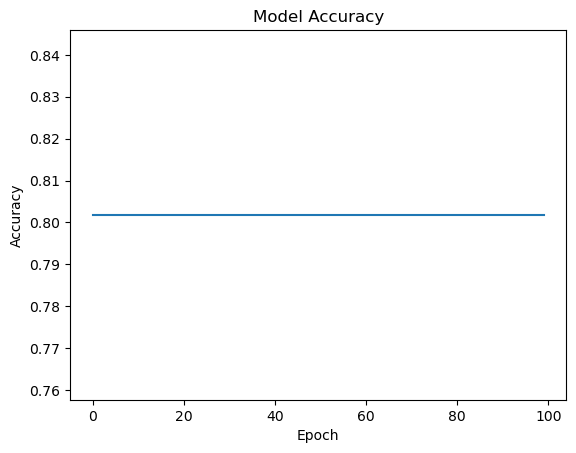

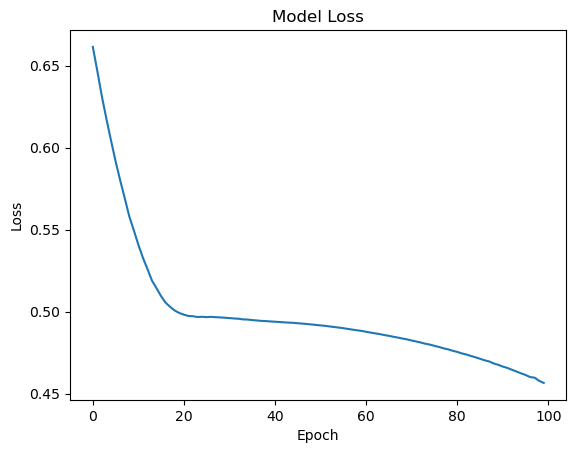

In [160]:
from matplotlib import pyplot as plt
# Plot accuracy
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [161]:
model.save("GP039.keras")